In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

from sys import path
from os.path import abspath
path.append(abspath("/home/ng136/nico"))
import ng_functions as ng

from copy import deepcopy
from glob import glob
from pathlib import Path
import warnings
from time import time
from tqdm import tqdm
from datetime import datetime


import scvelo as scv

# Useful dictionaries

In [3]:
n_states_dict = {'N1a' : 'Sell+Ngp+ neutrophils',
                 'N1b' : 'Sell+Lst1+ neutrophils',
                 'N2' : 'Sell+Cxcl10+ neutrophils',
                 'N3' : 'Cxcl3+ neutrophils',
                 'N4' : 'Siglecf+Xbp1+ neutrophils',
                 'N5' : 'Siglecf+Ccl3+ neutrophils',
                 'N6' : 'Siglecf+Ngp+ neutrophils'}

neu_palette_dict = {'Sell+Ngp+ neutrophils': '#6EA6CD',
                    'Sell+Lst1+ neutrophils': '#4A7BB7',
                    'Sell+Cxcl10+ neutrophils': '#364B9A',
                    'Cxcl3+ neutrophils': '#EAECCC',
                    'Siglecf+Xbp1+ neutrophils': '#A50026',
                    'Siglecf+Ccl3+ neutrophils': '#DD3D2D',
                    'Siglecf+Ngp+ neutrophils': '#F67E4B'}

In [4]:
exp2_samples = ['D2_S1', 'D2_S2', 'D2_S3', 'D2_S4', 'D2_S5', 'D2_S6']
n_states = ['N1a', 'N1b', 'N2', 'N3', 'N4', 'N5', 'N6']

sample_dict = {'D2_S1' : '1.KP19',
                'D2_S2' : '1.WT',
                'D2_S3' : '1.KP19_CD101',
                'D2_S4' : '2.KP19',
                'D2_S5' : '2.WT',
                'D2_S6' : '2.KP19_CD101'}

lane_per_sample = {'D2_S1': '1',
                   'D2_S2': '1',
                   'D2_S3': '1',
                   'D2_S4': '2',
                   'D2_S5': '2',
                   'D2_S6': '2'}

# Import embedded data

In [5]:
adata = sc.read('/n/groups/klein/nico/neutrophils/backups/totalseq_exp2_neutrophils_untreated_annotated_embedding_5258x13126_backup_220422_15h46.h5ad')

# Import loom files from each

In [6]:
vdict = {sample: scv.read(f'/n/groups/klein/nico/neutrophils/data/velocyto/neutrophils_totalseq_01292021/{sample}/{sample}.loom') for sample in exp2_samples}

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [7]:
for k,v in vdict.items():
    v.var_names_make_unique()
    v.obs['sampleID'] = v.obs['library_name'] = v.obs_names.map(lambda x : x.split(':')[0]).map(sample_dict)
    v.obs['barcode'] = v.obs_names.map(lambda x : x.split(':')[-1][:-1] + '-1')
    v.obs['cellID'] = v.obs.merge(adata.obs, left_on=['library_name', 'barcode'], 
                                  right_on=['library_name', 'barcode'], how='left')['cellID'].values
    
    v.obs_names = v.obs['cellID'].rename(None)
    vdict[k] = v[~v.obs['cellID'].isna()]

# Merge and preprocess together

In [8]:
vdata = sc.concat(vdict)

In [9]:
inherited_umap = pd.DataFrame(adata.obsm['X_umap'], index=adata.obs_names, columns=['X_umap1', 'X_umap2'])
vdata.obsm['X_umap'] = vdata.obs.join(inherited_umap).iloc[:,-2:].values
vdata.obs['smoothed_Zilionis'] = adata.obs['smoothed_Zilionis']

vdata = vdata[vdata.obs['smoothed_Zilionis'].isin(n_states)]

vdata.obs['neutrophil_subset'] = vdata.obs['smoothed_Zilionis'].map(n_states_dict).astype('category')
vdata.obs['neutrophil_subset'] = vdata.obs['neutrophil_subset'].cat.reorder_categories(sorted(vdata.obs['neutrophil_subset'].cat.categories))

vdata.uns['neutrophil_subset_colors'] = vdata.obs['neutrophil_subset'].cat.categories.map(neu_palette_dict)

Trying to set attribute `.obs` of view, copying.


In [10]:
scv.pp.filter_and_normalize(vdata, subset_highly_variable=False)


Normalized count data: X, spliced, unspliced.
Logarithmized X.


In [13]:
scv.pp.moments(vdata, use_highly_variable=False)


computing neighbors
    finished (0:00:19) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [33]:
scv.tl.velocity(vdata, mode='stochastic', filter_genes=False, use_highly_variable=False, min_r2=-1)

computing velocities
    finished (0:00:59) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [34]:
scv.tl.velocity_graph(vdata, n_jobs=4)

computing velocity graph (using 4/28 cores)


  0%|          | 0/5258 [00:00<?, ?cells/s]

    finished (0:04:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


... storing 'barcode' as categorical


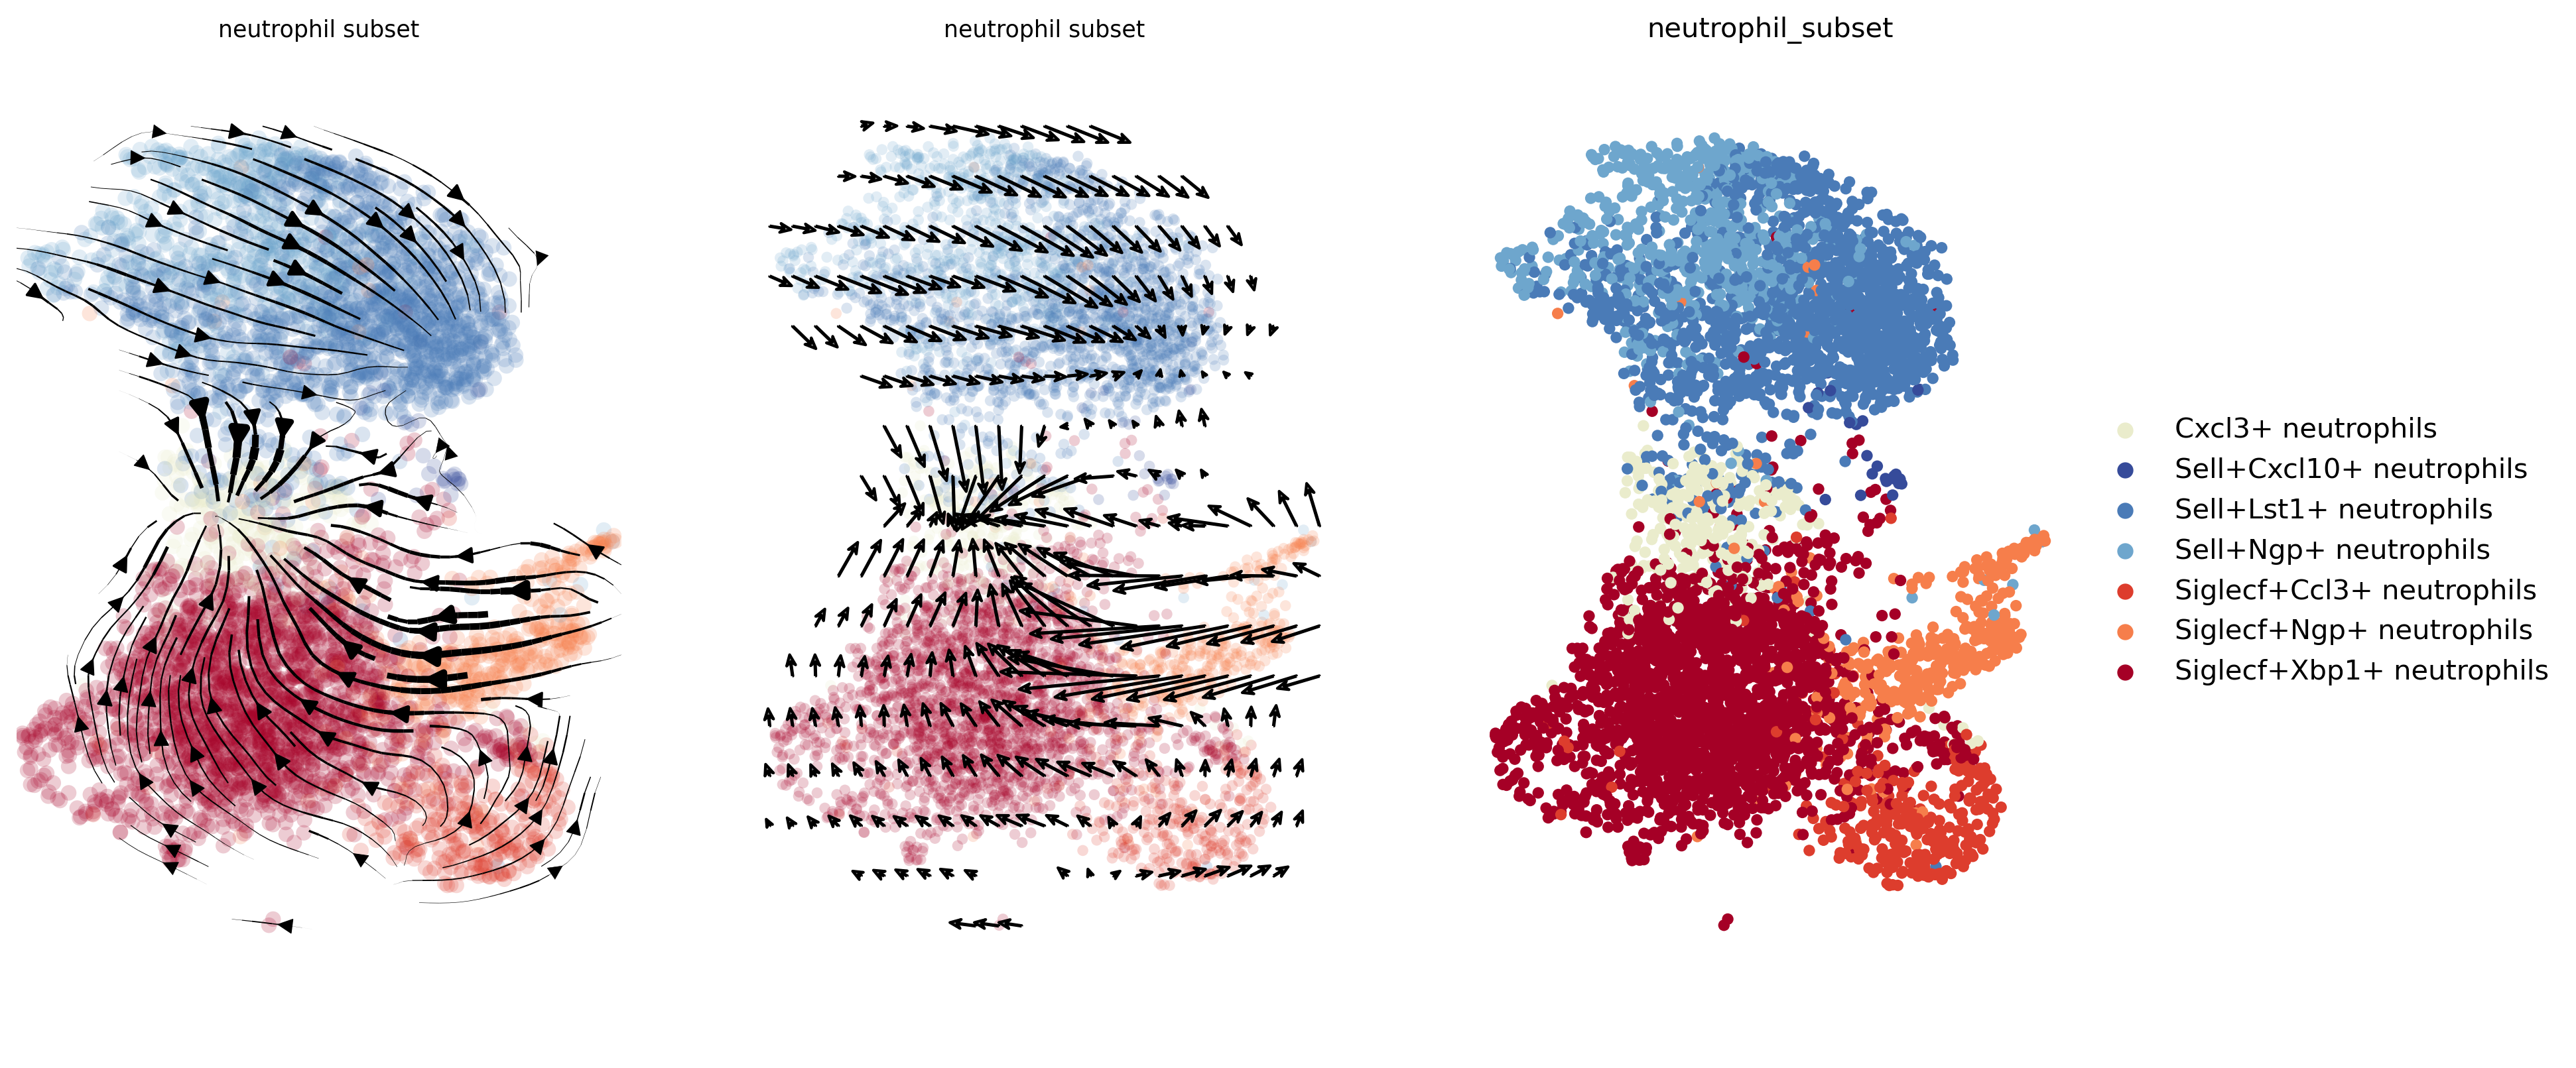

[None]

In [57]:
fig, axes = plt.subplots(1,3, figsize=(16,8), dpi=250)

scv.pl.velocity_embedding_stream(vdata, legend_fontsize=0, legend_fontoutline=0,
                                 basis='umap', color='neutrophil_subset', ylim=(0,20),ax=axes[0], show=False, arrow_size=1.5, linewidth=2, alpha=0.2, legend_loc='none')

scv.pl.velocity_embedding_grid(vdata, legend_fontoutline=0,
                                 basis='umap', color='neutrophil_subset', legend_fontsize=0,
                               ylim=(0,20),ax=axes[1], show=False, arrow_size=3, scale=1, arrow_length=2.5, density=0.5, linewidth=1.2)

axes[2].set_ylim((0,20))
ng.umap_plot(vdata, color='neutrophil_subset', s=100, legend_fontsize=12, legend_loc='right margin',
             ax=axes[2], return_fig=False, show_fig=False, frameon=False)

#plt.gcf().set_size_inches([8,8])

# Save

In [58]:
start = time()
fname = '/n/groups/klein/nico/neutrophils/backups/totalseq_exp2_neutrophils_scvelo_{}x{}_backup_{}.h5ad'.format(*vdata.shape,ng.now())
vdata.write(fname)
print(fname)
ng.print_etime(start)

... storing 'barcode' as categorical


/n/groups/klein/nico/neutrophils/backups/totalseq_exp2_neutrophils_scvelo_5258x32285_backup_220630_17h24.h5ad
Elapsed time: 0 minutes and 10.2 seconds.
